# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize

In [3]:
import sys
sys.path.append("../smote_cd/")
from smote_cd.dataset_generation import softmax

In [4]:
import dirichlet_regression

In [5]:
from scipy.optimize import fmin, newton, minimize

# With Maupiti

In [6]:
def f_maupiti(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [7]:
def fprime_maupiti(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, X, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, X, Y, Z, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad]))

In [8]:
X_maupiti = pd.read_csv('../../Maupiti/maupiti_X_13244.csv', index_col=0)
Y_maupiti = pd.read_csv('../../Maupiti/maupiti_Y_13244.csv',index_col=0)

In [9]:
n_features = X_maupiti.shape[1]
n_classes = Y_maupiti.shape[1]
n_samples = X_maupiti.shape[0]

In [10]:
X_maupiti = np.array(X_maupiti)
Y_maupiti = np.array(Y_maupiti)

In [11]:
X_maupiti = (X_maupiti-np.min(X_maupiti))/(np.max(X_maupiti)-np.min(X_maupiti))

In [12]:
Z_maupiti = np.ones((n_samples,n_features))

In [13]:
#X_maupiti_2 = np.ones((n_samples,1+n_features*2))
#X_maupiti_2[:,1:1+n_features] = X_maupiti
#X_maupiti_2[:,1+n_features:] = X_maupiti**2

X_maupiti_1 = np.ones((n_samples,1+n_features))
X_maupiti_1[:,1:] = X_maupiti

In [14]:
Y_star_maupiti = (Y_maupiti*(n_samples-1)+1/n_classes)/n_samples

In [15]:
beta_maupiti = np.zeros((1+n_features)*n_classes+(1+n_features))[:(1+n_features)*n_classes].reshape(((1+n_features),n_classes))
beta_maupiti[:,0] = 0

In [16]:
gamma_maupiti = np.zeros(Z_maupiti.shape[-1])

In [17]:
params0_maupiti = np.concatenate([beta_maupiti.flatten(),gamma_maupiti])

In [29]:
X_maupiti_train = X_maupiti_1[6000:8000,:]
Y_star_maupiti_train = Y_star_maupiti[6000:8000,:]
Z_maupiti_train = Z_maupiti[6000:8000]

In [30]:
%%time
solution_maupiti = minimize(f_maupiti, params0_maupiti, args=(X_maupiti_train, 
                                                             Y_star_maupiti_train, 
                                                             Z_maupiti_train), jac=fprime_maupiti)

Wall time: 2min 23s


In [31]:
solution_maupiti.x

array([ 0.00000000e+00, -1.50071639e+00, -1.93712174e+00, -1.64056724e+00,
       -1.63147806e+00, -1.87374731e+00, -2.12777477e+00, -1.70398897e+00,
       -1.61656110e+00, -1.24978144e+00,  0.00000000e+00, -2.45268258e+04,
       -1.12312481e+04, -1.47394363e+04, -1.38336589e+04, -1.20359450e+04,
       -1.30204049e+04, -1.10170633e+04, -9.96942210e+03, -1.73756589e+04,
        0.00000000e+00,  1.30685251e+00,  1.78612316e+01,  1.70513206e+00,
        6.88562682e-01, -6.60996957e-01, -3.38272416e+01, -2.76113686e+00,
       -5.47957335e+00,  1.66365495e+00,  0.00000000e+00, -5.14962868e+05,
        1.43167246e+05,  1.38866383e+05,  4.72827775e+04,  3.37346040e+05,
       -2.91873909e+05, -1.45263493e+04, -1.16020168e+05, -6.69045994e+04,
        0.00000000e+00,  5.28009550e+04,  2.52707921e+05,  1.67015694e+05,
        8.12737408e+04,  9.95404848e+04, -1.09282914e+05,  1.37552116e+05,
       -7.23031105e+04,  1.05818504e+05,  0.00000000e+00,  2.74792302e+04,
        1.73504639e+04,  

In [32]:
beta_solution = solution_maupiti.x[:n_classes*(n_features+1)].reshape((1+n_features,n_classes))

In [33]:
mu_maupiti = dirichlet_regression.compute_mu(X_maupiti_train, beta_solution)

In [34]:
r2_score(Y_star_maupiti_train, mu_maupiti)

-0.12264695212148884

In [35]:
mu_maupiti_pred = dirichlet_regression.compute_mu(X_maupiti_1, beta_solution)
r2_score(Y_star_maupiti, mu_maupiti_pred)

-0.0011870787313253638

In [19]:
Y_maupiti_bis = np.array([j for j in Y_maupiti if np.all(j != 1)])
X_maupiti_bis = np.array([X_maupiti[j] for j in range(n_samples) if np.all(Y_maupiti[j] != 1)])
Z_maupiti_bis = np.array([Z_maupiti[j] for j in range(n_samples) if np.all(Y_maupiti[j] != 1)])

In [20]:
X_maupiti_1_bis = np.ones((len(X_maupiti_bis),1+n_features))
X_maupiti_1_bis[:,1:] = X_maupiti_bis

In [21]:
Y_star_maupiti_bis = (Y_maupiti_bis*(n_samples-1)+1/n_classes)/n_samples

In [22]:
%%time
solution_maupiti = minimize(f_maupiti, params0_maupiti, args=(X_maupiti_1_bis[:500], 
                                                             Y_star_maupiti_bis[:500], 
                                                             Z_maupiti_bis[:500]), jac=fprime_maupiti)

Wall time: 39.4 s


In [24]:
beta_solution_bis = solution_maupiti.x[:n_classes*(n_features+1)].reshape((1+n_features,n_classes))
mu_maupiti_bis = dirichlet_regression.compute_mu(X_maupiti_1_bis, beta_solution_bis)

In [27]:
print('R2 :',r2_score(Y_star_maupiti_bis, mu_maupiti_bis))
print('RMSE :',mean_squared_error(Y_star_maupiti_bis, mu_maupiti_bis, squared=False))

R2 : 0.09565638333505186
RMSE : 0.2152327014704051


### With an intercept

In [20]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]

In [21]:
beta0 = np.array([[0., -0.3, -1.1],[ 0., 0.05, 0.06]])
gamma0 = [0]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [22]:
%%time
solution_arctic_bis=minimize(f_arctic, params0, args=(X_arctic_1, Y_arctic, Z_arctic))

Wall time: 1.05 s


In [23]:
solution_arctic_bis

      fun: -77.72809940034881
 hess_inv: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  3.98231064e-02, -1.59404468e-02,
         0.00000000e+00, -8.34169677e-04, -9.75243008e-05,
         8.26420183e-03],
       [ 0.00000000e+00, -1.59404468e-02,  7.86797721e-02,
         0.00000000e+00,  5.01970702e-04, -7.19055184e-04,
         2.09865555e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -8.34169677e-04,  5.01970702e-04,
         0.00000000e+00,  2.52374950e-05,  6.75566155e-06,
        -1.21204465e-04],
       [ 0.00000000e+00, -9.75243008e-05, -7.19055184e-04,
         0.00000000e+00,  6.75566155e-06,  1.65090097e-05,
        -2.79859698e-04],
       [ 0.00000000e+00,  8.26420183e-03,  2.09865555e-02,
         0.00000000e+00, -1.21204465

In [24]:
beta_arctic_1 = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))

In [25]:
X_new_1 = np.arange(10.4,103.7,0.5)
X_new_1 = np.array([[1., j] for j in X_new_1])

In [26]:
mu_arctic_1 = dirichlet_regression.compute_mu(X_new_1, beta_arctic_1)

gamma_var_arctic_1 = solution_arctic_bis.x[(n_features+1)*n_classes:]
phi_arctic_1 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1))

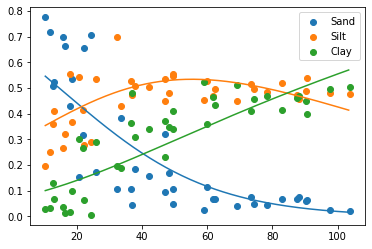

In [27]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_1)
plt.legend()
plt.show()

## With X^2

In [28]:
X_arctic_2 = np.ones((39,3))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2[:,2] = X_arctic[:,0]**2

In [29]:
beta0 = np.array([[ 0., -1.5, -4.], [0, 0.05, 0.1], [0., 0.01, 0.01]])
gamma0 = [2.]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [30]:
%%time
solution_arctic_bis=minimize(f_arctic, params0, args=(X_arctic_2, Y_arctic, Z_arctic))

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))
C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))


Wall time: 5.08 s


In [31]:
solution_arctic_bis.message

'Desired error not necessarily achieved due to precision loss.'

In [32]:
beta_arctic_2 = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

In [33]:
beta_arctic_2

array([[ 0.00000000e+00, -1.74783202e+00, -4.15660264e+00],
       [ 0.00000000e+00,  9.50075706e-02,  1.55216418e-01],
       [ 0.00000000e+00, -5.86263525e-04, -9.61258622e-04]])

In [34]:
X_new_2 = np.arange(10.4,103.7,0.5)
X_new_2 = np.array([[1., j, j**2] for j in X_new_2])

In [35]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

#gamma_var_arctic_2 = solution_arctic_bis[(n_features+2)*n_classes:]
#phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

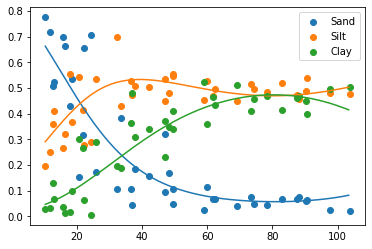

In [36]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

# Using the derivatives

In [101]:
X_arctic_2_bis = np.ones((39,3))
X_arctic_2_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)
X_arctic_2_bis[:,2] = X_arctic_2_bis[:,1]**2

In [88]:
def fprime_arctic(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    #mu = dirichlet_regression.compute_mu(X, beta)
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    #beta_grad = dirichlet_regression.dirichlet_gradient(mu, X, Y, epsilon=epsilon)
    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, X, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, X, Y, Z, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad]))

In [89]:
h=0.000001
params0_h = np.copy(params0)
params0_h[-2] += h 
(f_arctic(params0_h, X_arctic_2, Y_arctic, Z_arctic)-f_arctic(params0, X_arctic_2, Y_arctic, Z_arctic))/h

271402.53057746124

In [90]:
fprime_arctic(params0, X_arctic_2, Y_arctic, Z_arctic)

array([-0.00000000e+00,  2.44803858e+00,  4.54959527e+01, -0.00000000e+00,
       -1.40671295e+03,  3.41001611e+03, -0.00000000e+00, -1.49382795e+05,
        2.71310732e+05,  4.12946026e+01])

In [91]:
%%time
solution_arctic = minimize(f_arctic, params0, args=(X_arctic_2, Y_arctic, Z_arctic), jac=fprime_arctic)

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  exp_Xbeta = np.exp(Xbeta)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))


Wall time: 437 ms


In [92]:
solution_arctic.message

'Desired error not necessarily achieved due to precision loss.'

In [93]:
beta_arctic_2 = solution_arctic.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

In [94]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

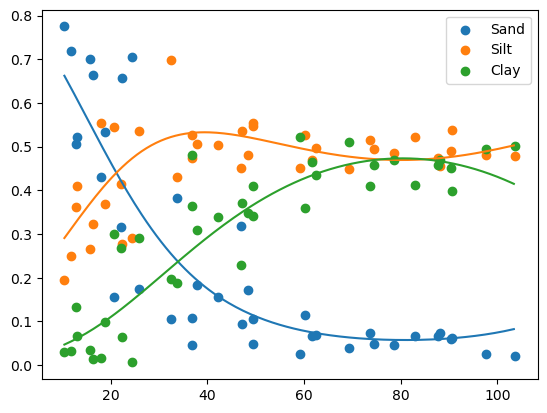

In [97]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

In [465]:
def fhessian(x, X, Y, Z):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    #mu = dirichlet_regression.compute_mu(X, beta)
    mu = dirichlet_regression.compute_mu_2(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    if len(phi.shape)==1:
        K_phi=1
    else:
        K_phi = phi.shape[-1]
    hessian = np.zeros((K*J+1,K*J+1))
    #beta_hess = dirichlet_regression.dirichlet_hessian_wrt_beta(mu, phi, X, Y).reshape((K*J,K*J))
    beta_hess = dirichlet_hessian_wrt_beta_2(mu, phi, X, Y).reshape((K*J,K*J))
    #gamma_hess = dirichlet_regression.dirichlet_hessian_wrt_gamma(mu, phi, beta, X, Y, Z)
    gamma_hess = dirichlet_regression.dirichlet_hessian_wrt_gamma_2(mu, phi, beta, X, Y, Z)
    #beta_gamma_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma(mu, phi, beta, X, Y, Z).reshape((K_phi,K*J))
    beta_gamma_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma_2(mu, phi, beta, X, Y, Z).reshape((K_phi,K*J))
    
    # we set to 0 the first columns of the betas
    for k in range(0,K*J,J):
        beta_hess[k,:] = 0
        beta_hess[:,k] = 0.
        beta_gamma_derivative[:,k] = 0.
    hessian[:K*J,:K*J] = beta_hess
    hessian[K*J:,K*J:] = gamma_hess
    hessian[:K*J,K*J:] = beta_gamma_derivative.transpose()
    hessian[K*J:,:K*J] = beta_gamma_derivative
    return(-hessian)

In [113]:
def trigamma_func(z):
    S=0
    for n in range(10000):
        S+=1/(z+n)**2
    return S

def z_times_trigamma_func(z):
    S=0
    for n in range(10000):
        S+=1/( z + 2*n + (n**2)/z )
    return S

def a_times_trigamma_func(a,z):
    S=0
    try:
        for n in range(10000):
            S+=1/( z*(z/a) + (2*z*n)/a + (n**2)/a )
    except ZeroDivisionError:
        S=1e305
    return S

In [236]:
def dirichlet_hessian_wrt_beta_2(mu, phi, X, Y, alpha=None, epsilon=0):
    K = np.shape(X)[1] #nb of features
    J = np.shape(Y)[1] #nb of classes
    n = np.shape(Y)[0] 
    hessian = np.zeros((K,J,K,J))
    if alpha is None:
        alpha = np.copy(mu)
        for j in range(J):
            alpha[:,j] = phi*mu[:,j]
    for i in range(n):
        digamma_alpha = digamma(alpha[i])
        digamma_alpha[np.isinf(digamma_alpha)] = -1e305

        trigamma_alpha = polygamma(1,alpha[i])
        trigamma_alpha[np.isinf(trigamma_alpha)] = 1e305
        
        #mu_2_trigamma = a_times_trigamma_func(mu[i]**2,alpha[i])
        #if math.isinf(trigamma_alpha):
        #    mu_2_trigamma = a_times_trigamma_func(mu[i]**2,alpha[i])
        #else:
        mu_2_trigamma = mu[i]**2*trigamma_alpha
        mu_2_trigamma[mu[i]**2==0] = 0
        phi_sum_mu_2_trigamma = phi[i]*np.sum(mu_2_trigamma)
        
        logY = np.log(Y[i]+epsilon)
        sum_mu_log = 2*np.sum(mu[i]*logY)
        
        mu_digamma_alpha = mu[i]*digamma_alpha
        mu_digamma_alpha[mu[i]==0] = 0
        sum_mu_digamma = 2*np.sum(mu_digamma_alpha)
        
        mu_digamma_log = mu[i]*(digamma_alpha-logY)
        #mu_digamma_log[mu[i]==0] = 0
        sum_mu_digamma_log = np.sum(mu_digamma_log)
        for p in range(K):
            phi_Xip = phi[i]*X[i,p]
            for d in range(J):
                phi_Xip_muid = phi_Xip*mu[i,d]
                if alpha[i,d]==0:
                    alpha_times_trigamma_alpha = np.zeros(np.shape(trigamma_alpha[d]))
                else:
                    if math.isinf(trigamma_alpha[d]):
                        alpha_times_trigamma_alpha = np.array(a_times_trigamma_func(alpha[i,d],alpha[i,d]))
                    else:
                        alpha_times_trigamma_alpha = alpha[i,d]*trigamma_alpha[d]
                for q in range(K):
                    phi_Xip_muid_Xiq = phi_Xip_muid*X[i,q]
                    for c in range(J):
                        if c!=d:
                            if alpha[i,c]==0:
                                alpha_c_trigamma_alpha_c = 0
                            elif math.isinf(trigamma_alpha[c]):
                                alpha_c_trigamma_alpha_c = a_times_trigamma_func(alpha[i,c],alpha[i,c])
                            else:
                                alpha_c_trigamma_alpha_c = alpha[i,c]*trigamma_alpha[c]
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( digamma_alpha[c] + digamma_alpha[d]
                                                                           - logY[c] - logY[d]
                                                                           + alpha_c_trigamma_alpha_c + alpha_times_trigamma_alpha
                                                                           - phi_sum_mu_2_trigamma 
                                                                           + sum_mu_log
                                                                           - sum_mu_digamma )
                        else:
                            
                            if math.isinf(trigamma_alpha[c]):
                                #phi_trigamma_alpha_c = np.array(a_times_trigamma_func(phi[i],alpha[i,c]))
                                phi_trigamma_alpha_c = phi[i]*1e305
                            else:
                                phi_trigamma_alpha_c = phi[i]*trigamma_alpha[c]
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq*mu[i,c] * ( 2*digamma_alpha[c] - 2*logY[c] 
                                                                           + 2*alpha_times_trigamma_alpha
                                                                           - phi_sum_mu_2_trigamma
                                                                           + sum_mu_log
                                                                           - sum_mu_digamma
                                                                           - phi_trigamma_alpha_c)
                            hessian[p,d,q,c] += phi_Xip_muid_Xiq * (sum_mu_digamma_log - digamma_alpha[c] + logY[c] )
    # fill the symmetric values we didn't compute
    #for p in range(K):
    #    for d in range(J):
    #        for q in range(p):
    #            for c in range(J):
    #                hessian[p,d,q,c] = hessian[q,c,p,d]
    return hessian